In [1]:
# HIDE
import pandas as pd
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette=[sns.color_palette('muted')[i] for i in [0,2]], 
        color_codes=True, context="talk")
from IPython import display
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

# import keras as ke
# import keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

create_gif = False

print(f"sklearn: {sk.__version__}")
print(f"pandas: {pd.__version__}")
print(f"tensorflow: {tf.__version__}")

sklearn: 0.24.2
pandas: 1.3.4
tensorflow: 2.9.0


In [2]:
def load_ICU_data(path):
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                    'marital.status', 'occupation', 'relationship', 'race', 'sex', 
                    'capital.gain', 'capital.loss', 'hours.per.week', 'country', 'target']
    input_data = (pd.read_csv(path, names=column_names, 
                              na_values="?", sep=r'\s*,\s*', engine='python')
                  .loc[lambda df: df['sex'].isin(['Male', 'Female'])])

    # sensitive attributes; we identify 'race' and 'sex' as sensitive attributes
    # sensitive attributes; we identify 'race' and 'sex' as sensitive attributes
    sensitive_attribs = ['sex']
    Z = (input_data.loc[:, sensitive_attribs]
         .assign(sex=lambda df: (df['sex'] == 'Male').astype(int)))

    # targets; 1 when someone makes over 50k , otherwise 0
    y = (input_data['target'] == '>50K').astype(int)

    # features; note that the 'target' and sentive attribute columns are dropped
    X = (input_data
         .drop(columns=['target', 'sex'])
         .fillna('Unknown')
         .pipe(pd.get_dummies, drop_first=True))
    
    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape[0]} samples")
    print(f"sensitives Z: {Z.shape[0]} samples, {Z.shape[1]} attributes")
    return X, y, Z

In [3]:
X, y, Z = load_ICU_data(r"C:\Users\reemn\Downloads\fairness-in-ml-master\fairness-in-ml-master\data\adult.data")

features X: 32561 samples, 99 attributes
targets y: 32561 samples
sensitives Z: 32561 samples, 1 attributes


In [4]:
# split into train/test set
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.5, 
                                                                     stratify=y, random_state=7)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler)

In [5]:
def nn_classifier(n_features):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    outputs = Dense(1, activation='sigmoid')(dropout3)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# initialise NeuralNet Classifier
clf = nn_classifier(n_features=X_train.shape[1])

# train on train set
history = clf.fit(X_train.values, y_train.values, epochs=20, verbose=0)

In [6]:
# predict on test set
y_pred = pd.Series(clf.predict(X_test.values).ravel(), index=y_test.index)
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.2f}")
print(f"Accuracy: {100*accuracy_score(y_test, (y_pred>0.5)):.1f}%")

509/509 [==============================] - 0s 718us/step
ROC AUC: 0.91
Accuracy: 85.2%


In [7]:
# HIDE
def plot_distributions(y, Z, iteration=None, val_metrics=None, p_rules=None, fname=None):
    fig, axes = plt.subplots(1,2, figsize=(10, 4), sharey=True)
    legend={'sex': ['female','male']}
    for idx, attr in enumerate(Z.columns):
        for attr_val in [0,1]:
            ax = sns.kdeplot(data=y[Z[attr] == attr_val],
                             label='{}'.format(legend[attr][attr_val]), 
                             ax=axes[idx], fill=True)
        ax.set_xlim(0,1)
        ax.set_ylim(0,7)
        ax.set_yticks([])
        ax.set_title("sensitive attibute: {}".format(attr))
        if idx == 0:
            ax.set_ylabel('prediction distribution')
        ax.set_xlabel(r'$P({{income>50K}}|z_{{{}}})$'.format(attr))
    if iteration:
        fig.text(1.0, 0.9, f"Training iteration #{iteration}", fontsize='16')
    if val_metrics is not None:
        fig.text(1.0, 0.65, '\n'.join(["Prediction performance:",
                                       f"- ROC AUC: {val_metrics['ROC AUC']:.2f}",
                                       f"- Accuracy: {val_metrics['Accuracy']:.1f}"]),
                 fontsize='16')
    if p_rules is not None:
        fig.text(1.0, 0.4, '\n'.join(["Satisfied p%-rules:"] +
                                     [f"- {attr}: {p_rules[attr]:.0f}%-rule" 
                                      for attr in p_rules.keys()]), 
                 fontsize='16')
    fig.tight_layout()
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight',  dpi = 300)
    return fig

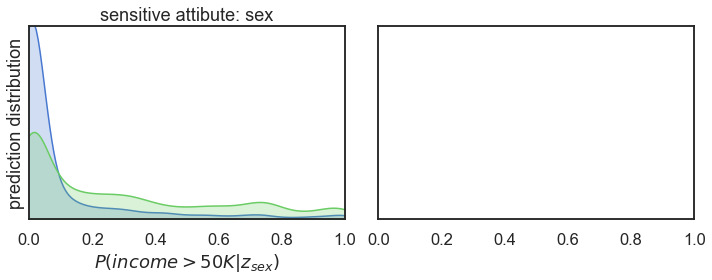

In [8]:
fig = plot_distributions(y_pred, Z_test, fname=r'C:\Users\reemn\Downloads\fairness-in-ml-master\fairness-in-ml-master\images/biased_training.png')